# Tutorial 2

In this tutorial we repeat the calculation from Tutorial 1, but now explain and explore some of the options available. 


### Step 1 --  Setting up the FingerPrint class

When setting up an instance of the ```FingerPrint``` class a number of options can be provided. These parameters are as follows:

- ```lmax```: The truncation degree for spherical harmonics used within the calculations. The default value is 256.
- ```earth_model_parameters```: An instance of the class ```EarthModelParameter``` that sets units for non-dimensionalisation along with values for various parameters for the earth model. The default non-dimensionalisation uses the SI base units, while the default parameters are for PREM (Dziewonski & Anderson, 1981).
- ```grid```: The form of the spatial grid chosen from the options for the ```pyshtools``` library. The default is ```"DH"```
- ```extend```: If ```True``` the spatial grid is extended to include longitude 360 as well as 0. Default is ```True```.
- ```love_number_file```: The path to the  Love number file. The default is for PREM (Dziewonski & Anderson, 1981) with values up to degree 4096. 

For most users ```lmax``` will be the parameter of most interest, this value controlling the spatial resolution of the calculations. 

In the example below we set up a ```FingerPrint``` instance using some non-default values. In particular, we set up a sensible non-dimensionalisation scheme for geophysical applications, while we choose to work with a Gauss-Legendre grid instead of the default Driscoll-Healy one. We also set ```extend``` equal to false. 

In [23]:
# Import necessary modules for this notebook. 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyshtools import  SHGrid
from pyslfp import FingerPrint, EarthModelParamters, IceNG

# Set up the earth model parameters
parameters = EarthModelParamters(length_scale=1e3, mass_scale=  1e12, time_scale=1e7)

# Set up fingerprint based on a Gauss-Legendre quadrature grid
fingerprint = FingerPrint(lmax = 512, earth_model_parameters=parameters, grid="GLQ", extend=False)

Having constructed the class instance, we have access to a range of physical properties in non-dimensional form. For example:

In [24]:
print(f'Density scale {fingerprint.density_scale} in kg/m^3')
print(f'Radius of the Earth {fingerprint.mean_radius} in non-dimensional units')
print(f'Polar moment of inertia {fingerprint.polar_moment_of_inertia} in non-dimensional units')
print(f'density of ice {fingerprint.ice_density} in non-dimensional units')


Density scale 1000.0 in kg/m^3
Radius of the Earth 6371.0 in non-dimensional units
Polar moment of inertia 8.0359e+19 in non-dimensional units
density of ice 0.917 in non-dimensional units


Within the ```EarthParameters``` class default values are set for the various physical properties taken from the Earth. These parameters can be set directly within the class constructor if desired. 

Once constructed, the instance of the class ```FingerPrint``` has also set up the spatial and spectral discretisations that will be used within the fingerprint calculations. 
Below, for example, we generate the spatial field whose value is everywhere zero. This is an instance of the ```pyshtools``` class ```SHGrid```. If we print this object we see a list of its parameters. Internally the fingerprint calculations depend on certain ```pyshtools``` options are set for working with spherical harmonics transformations. These choices are detailed within the ```__init__``` method and should not be changed.

In [25]:
# Generate a zero-field
zero = fingerprint.zero_grid()

# Print out its parameters -- this being a feature of the SHGrid class. 
print(zero)

  name = None
  kind = 'real'
  grid = 'GLQ'
  extend = False
  nlat = 513
  nlon = 1025
  lmax = 512
  units = None


The latitudes and longitudes preent in the spatial grid can be accessed as follows:

In [26]:
lats = fingerprint.lats()
print(f'First five latitudes:\n {lats[:5]} ')

lons = fingerprint.lons()
print(f'First five longitudes:\n {lons[:5]} ')


First five latitudes:
 [89.73167218 89.3840757  89.03442647 88.68431344 88.33402447] 
First five longitudes:
 [0.         0.35121951 0.70243902 1.05365854 1.40487805] 


### Step 2 -- Selecting the background sea level and ice models

Until the initial sea level and ice thickness are set, various methods of the ```FingerPrint``` class cannot be set. For example, in the code below we try to access the ```sea_level``` property of the class instance but this raises a ```NotImplementedError```:

In [27]:
try:
    sea_level = fingerprint.sea_level
except NotImplementedError as e:
    print(e)

Sea level not set.


In Tutorial 1, we used the method ```set_state_from_ice_ng``` to set the intial sea level and ice thickness. There are two optional arguments for this method:
- ```version```: Selects which of the ice-ng models to use. The choices are ```5```, ```6``` and ```7``` inputed as integers. 
- ```date```: The date to use in ka measured from present-day backwards. This is input as a float. Linear interpolation is used if this data does not coincide with a time-slice within the model, or, if the data is out of range, constant interpolation is applied. 

In the example below we show set values from the last glacial maximum at 21ka from the ice-5g model. In these examples, we also demonstrate some of the plotting options, these all being built aroud the ```matplotlib``` and ```cartopy``` libraries. Of particular note is the option ```ice_projection``` which only plots values where ice is present. We also show here a plot of the ocean function, this field becoming available once the initial sea level and ice thickness are set. 

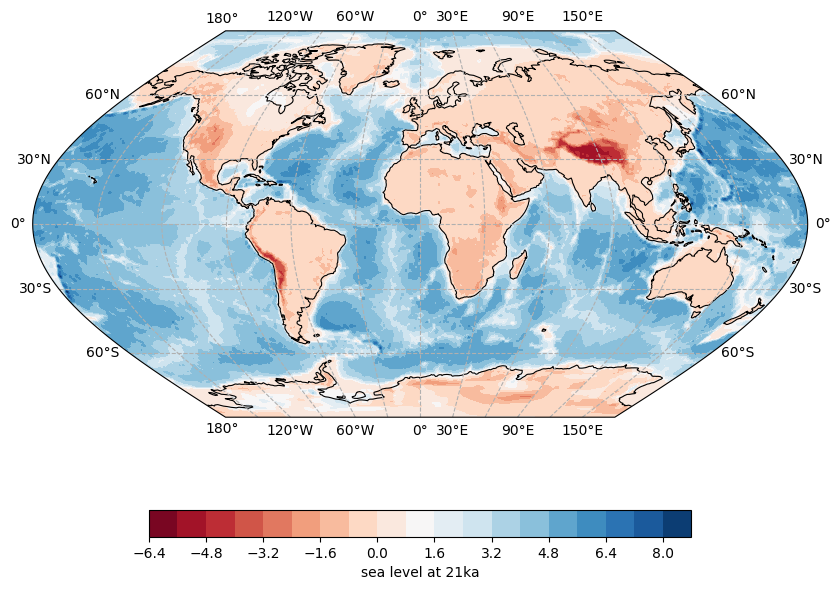

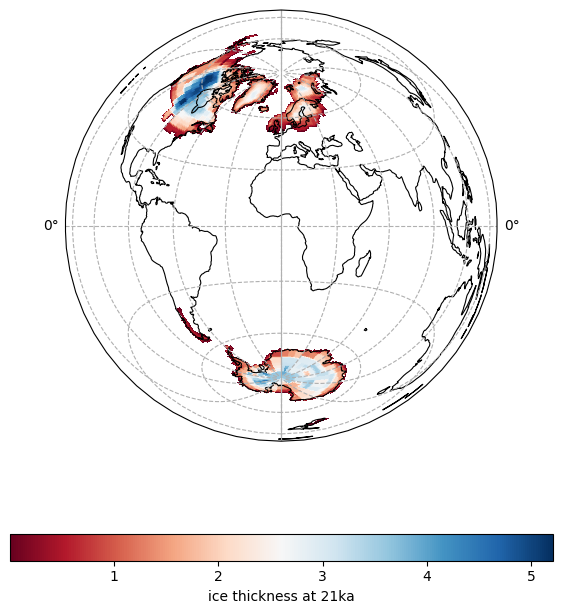

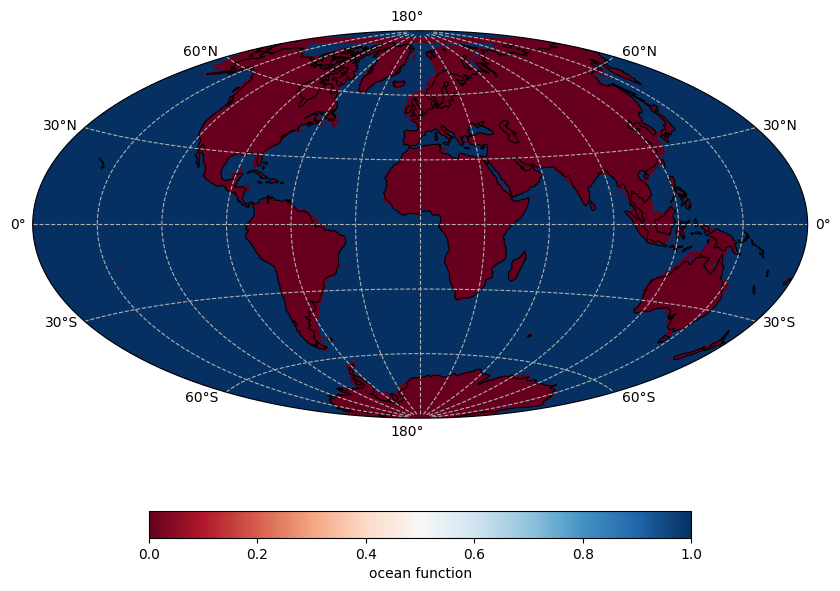

In [28]:
fingerprint.set_state_from_ice_ng(version=5, date=21)

fingerprint.plot(fingerprint.sea_level, projection=ccrs.EckertV(), colorbar=True, cbar_label="sea level at 21ka", contour=True, levels = 20)
fingerprint.plot(fingerprint.ice_thickness, projection=ccrs.LambertAzimuthalEqualArea(), ice_projection=True, colorbar=True, cbar_label="ice thickness at 21ka")
fingerprint.plot(fingerprint.ocean_function, projection=ccrs.Aitoff(),  colorbar=True, cbar_label="ocean function")
plt.show()

The values of ```sea_level``` and ```ice_thickness``` can also be set directly using suitable ```SHGrid``` objects. In the example below we illustrate this idea using a simple one contient world in which the northern hemisphere is all land and the sourthern all ocean. In plotting here we set ```coasts``` to ```False``` because the coast lines on the real Earth are not relevant to this contrived model. 

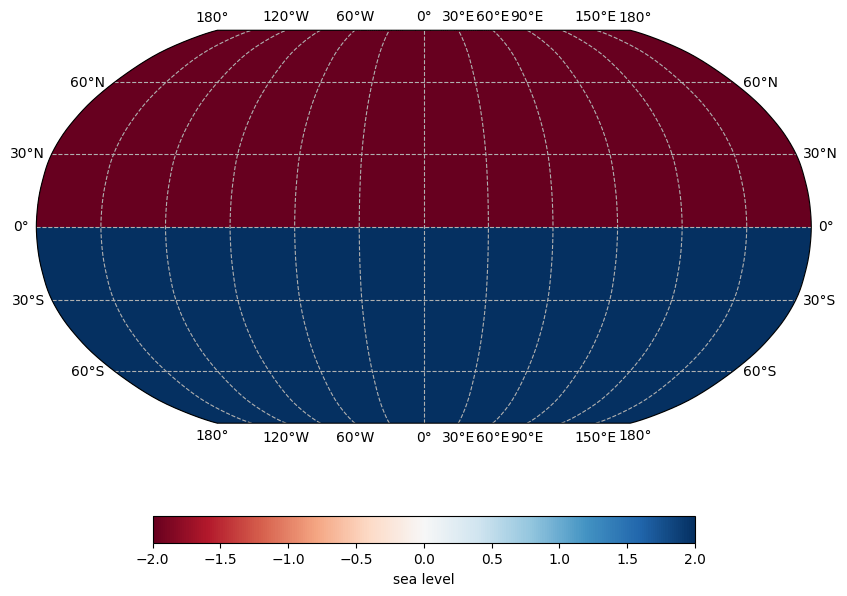

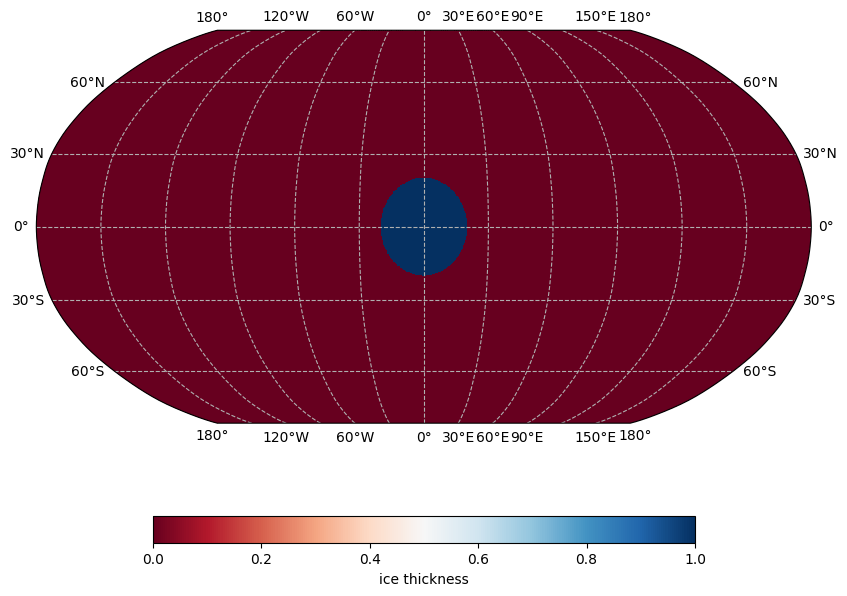

In [29]:

# Generate a numpy array of all latitudes
lats, _ = np.meshgrid(
            fingerprint.lats(),
            fingerprint.lons(),
            indexing="ij",
        )

# Construct the sea level values
sea_level_amplitude = 2e3/ fingerprint.length_scale
sea_level = SHGrid.from_array(np.where(lats < 0, sea_level_amplitude, -sea_level_amplitude), grid=fingerprint.grid)


# Now set the ice sheet thickness using a disk geometry of angular radius 20 degrees 
# and with centre at lat = 0, lon = 0:
ice_thickness_amplitude = 1e3 / fingerprint.length_scale
ice_thickness = fingerprint.disk_load(20, 0, 0, ice_thickness_amplitude)

# Set the values and plot the fields. 
fingerprint.sea_level = sea_level
fingerprint.ice_thickness = ice_thickness

fingerprint.plot(fingerprint.sea_level,  colorbar=True, cbar_label="sea level", coasts=False)
fingerprint.plot(fingerprint.ice_thickness,  colorbar=True, cbar_label="ice thickness", coasts=False)

plt.show()





### Step 3 -- Choosing the direct load. 

As previously, within a fingerprint calculation we need to select a direct load. Here we choose to melt 50% of the initial ice sheet. To proceed, we first define the change in ice thickness and then convert this into the associated direct load by setting:
$$
\zeta = \rho_{i}(1-C) \Delta I, 
$$
where $\zeta$ is the direct load, $\rho_{i}$ the density of ice, and $C$ the ocean function. This calculation is done using a class method. 

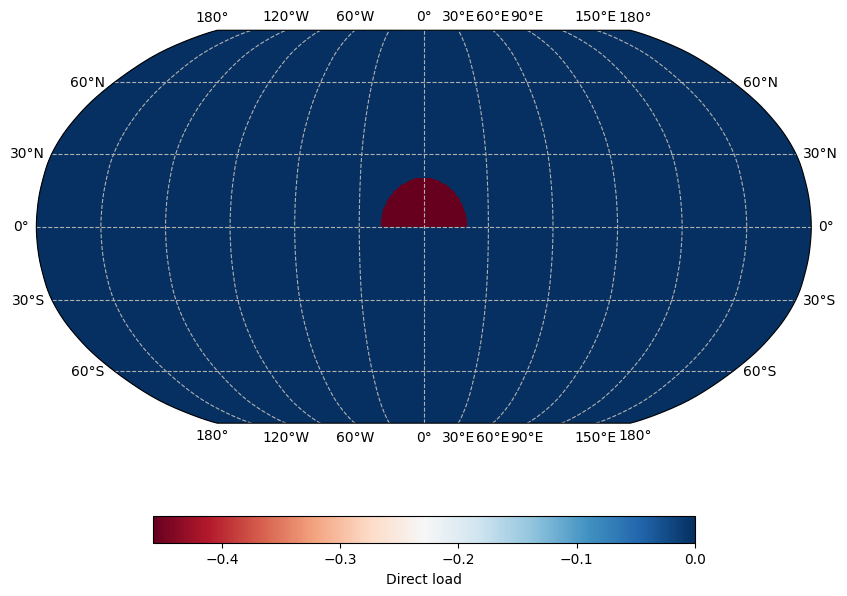

In [30]:
# Set the change in ice_thickness. 
ice_thickness_change = -0.5 * fingerprint.ice_thickness

# Convert to the direct load: 
direct_load = fingerprint.direct_load_from_ice_thickness_change(ice_thickness_change)

fingerprint.plot(direct_load, colorbar=True, cbar_label="Direct load", coasts=False)
plt.show()

### Step 4 -- Solve the sea level equation

We can now solve the sea level equation to find the resulting fingerprint. Here we list all of the optional arguments for the ```__call__``` method that are relevant to solving standard fingerprint problems. We also discuss the full outputs of the method. 

The relevant optional arguments are:
- ```direct_load```: This is an ```SHGrid``` object specifying the direct load to be used. 
- ```rotational_feedbacks```: If ```True``` rotational feedbacks are included in the calculations. Default is ```True```.
- ```rtol```: Relative tolerance used in the iterative solution of the sea level equation. Default is ```1e-6```.
- ```verbose```: If ```True``` relative errors are printed during the iterative solution. Default is ```False```. 

Four outputs are returned in the following order:
- ```sea_level_change```: An ```SHGrid``` of the change in sea level. 
- ```displacement```: The vertical displacement. 
- ```gravity_potential_change```: The change in gravity potential, i.e., the sum of the gravitational and centrifugal potentials. 
- ```angular_velocity_change```: The change in the angular velocity. Note that only x and y components are returned.

Currently the code cannot account for horizontal displacement and changes to the length of day are neglected. These features
may be added in at a later date, but neither is crucial for most applications. 

angular velocity change [ 5.10530690e-09 -2.43438564e-26]


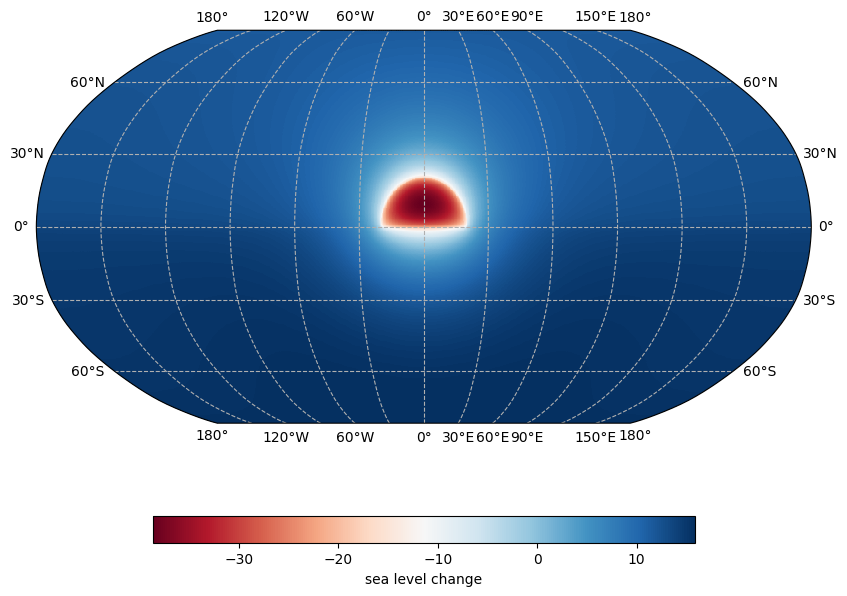

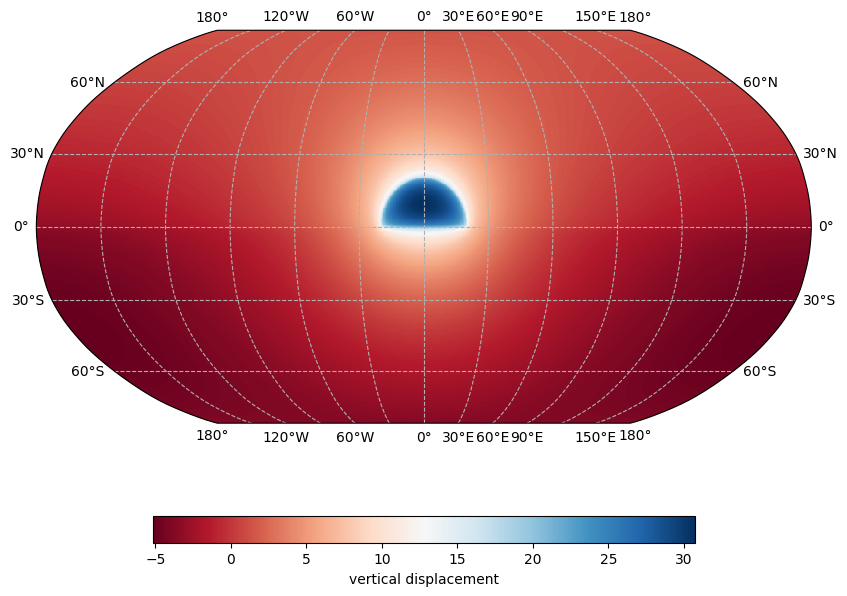

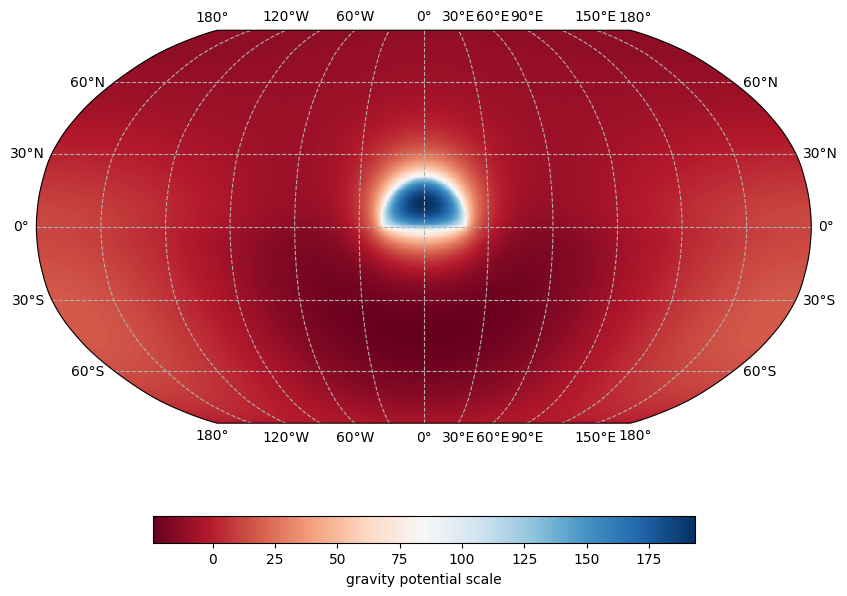

In [31]:
# Solve the sea level equation
(sea_level_change, 
displacement, 
gravity_potential_change,
angular_velocity_change)  = fingerprint(direct_load=direct_load, 
                                        rotational_feedbacks=True,
                                        rtol=1.0e-9,
                                        verbose=False)


fingerprint.plot(sea_level_change * fingerprint.length_scale,  colorbar=True, cbar_label="sea level change", coasts=False)    
fingerprint.plot(displacement * fingerprint.length_scale,  colorbar=True, cbar_label="vertical displacement", coasts=False)    
fingerprint.plot(gravity_potential_change *fingerprint.gravitational_potential_scale ,  colorbar=True, cbar_label="gravity potential scale", coasts=False)    
print(f'angular velocity change {angular_velocity_change * fingerprint.frequency_scale}')

plt.show()

The gravity potential change can be converted into a gravitational potential change by subtracting the centrifugal potential. This is shown in the code below. In the last plot we subtract the gravity and gravitational potential changes to isolate the centrifugal potential change. This provides a check on direct calculation of the centrifugal potential.  

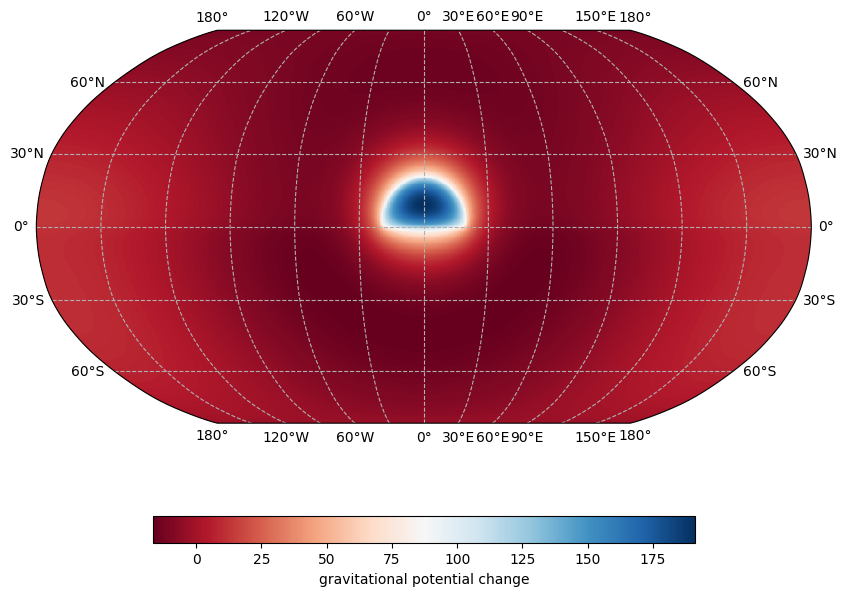

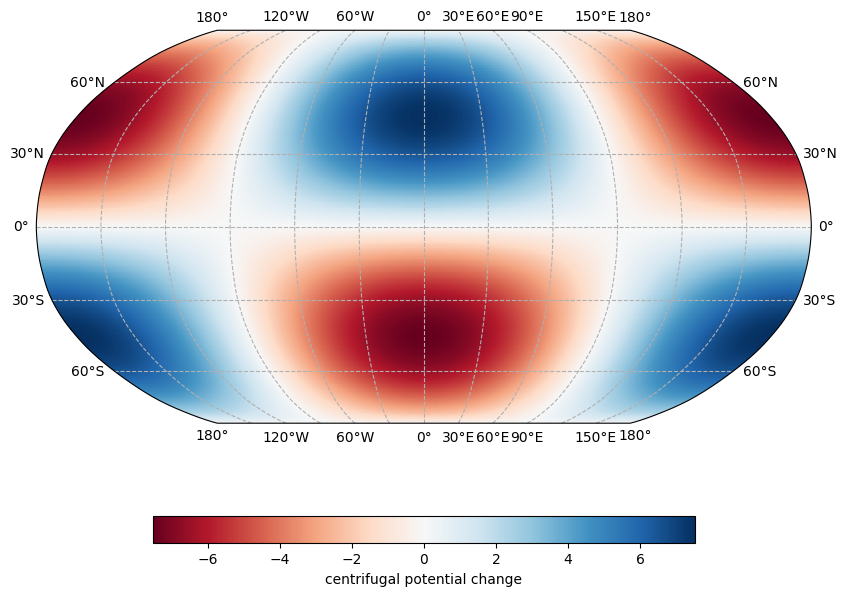

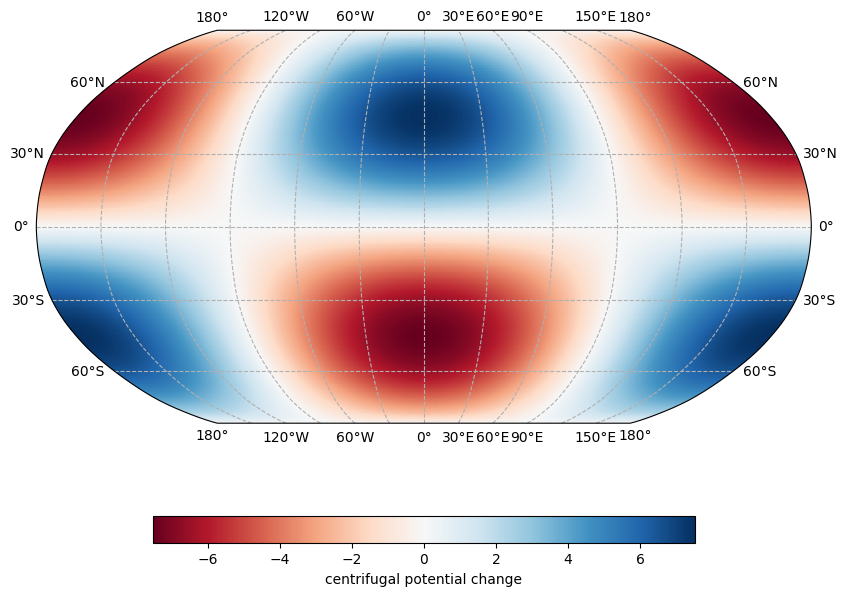

In [32]:
# Get the gravitational potential change.
gravitational_potential_change = fingerprint.gravity_potential_change_to_gravitational_potential_change(gravity_potential_change, angular_velocity_change)

# We can also generate the centrifugal potential change for plotting:
centrifugal_potential_change = fingerprint.centrifugal_potential_change(angular_velocity_change)

fingerprint.plot(gravitational_potential_change * fingerprint.gravitational_potential_scale, colorbar=True, cbar_label="gravitational potential change", coasts=False)    
fingerprint.plot(centrifugal_potential_change * fingerprint.gravitational_potential_scale, colorbar=True, cbar_label="centrifugal potential change", coasts=False)    
fingerprint.plot((gravity_potential_change - gravitational_potential_change) *fingerprint.gravitational_potential_scale, colorbar=True, cbar_label="centrifugal potential change", coasts=False)   

plt.show()

As a final example for this tutorial, we compare the result of the fingerprint calculation with and without rotational feedbacks:

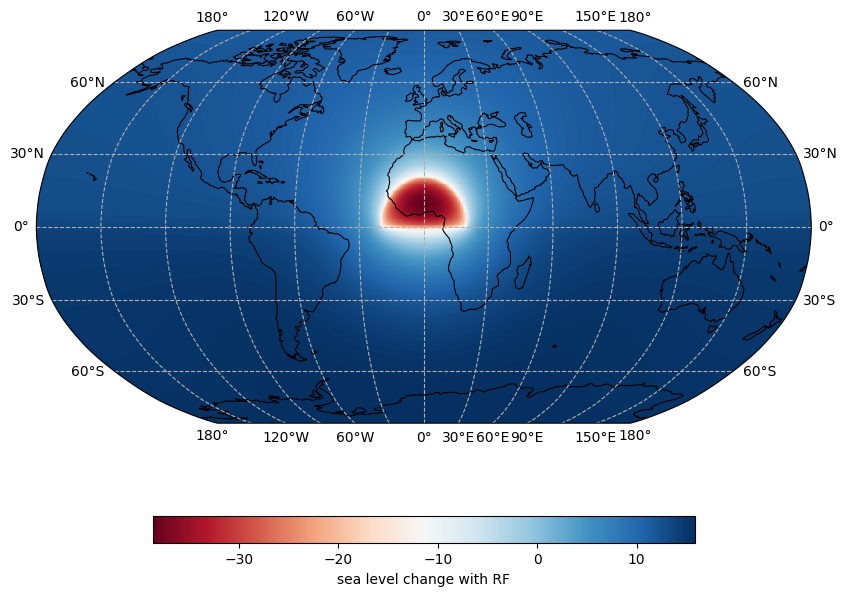

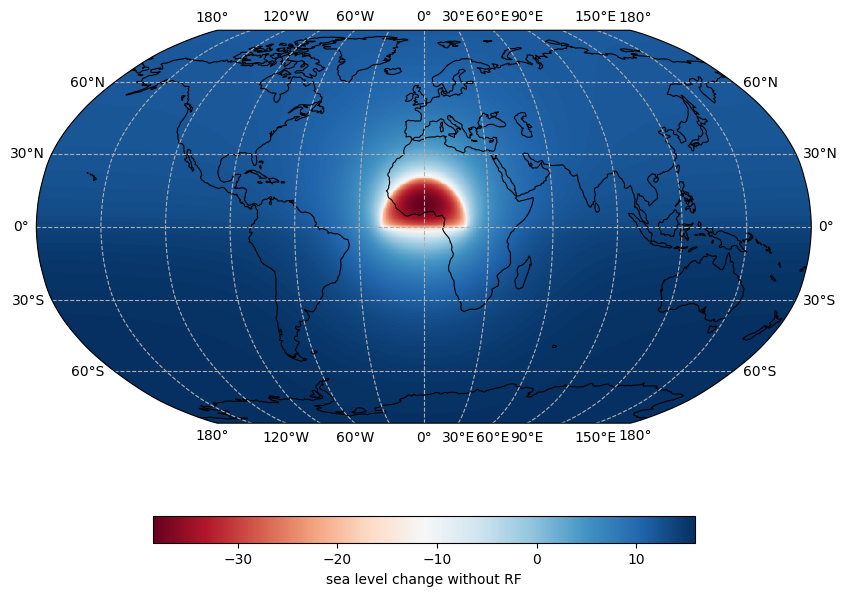

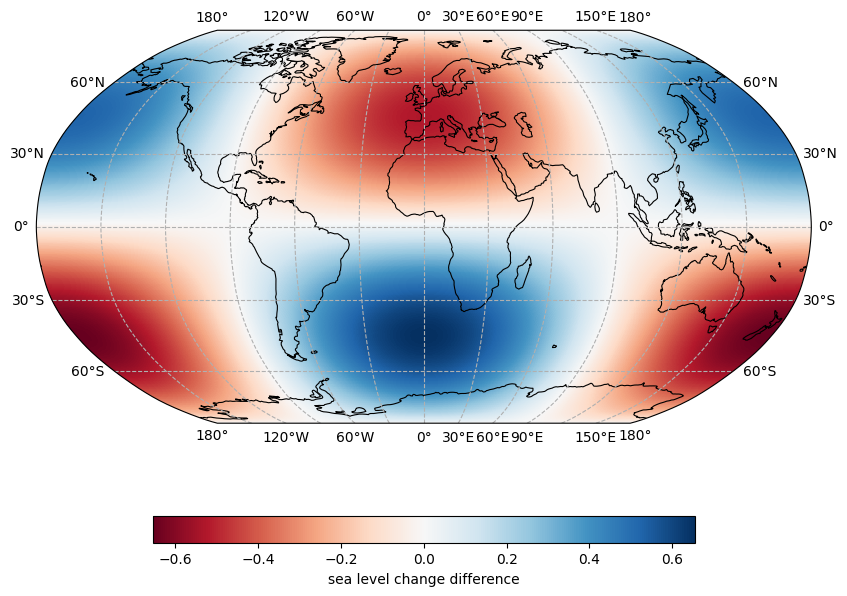

In [ ]:
sea_level_change_with_rotational_feedbacks, _, _, _ = fingerprint(direct_load=direct_load)
sea_level_change_without_rotational_feedbacks, _, _, _ = fingerprint(direct_load=direct_load, rotational_feedbacks=False)


fingerprint.plot(sea_level_change_with_rotational_feedbacks * fingerprint.length_scale,  
                 colorbar=True, cbar_label="sea level change with RF", coasts=False) 
fingerprint.plot(sea_level_change_without_rotational_feedbacks * fingerprint.length_scale,  
                 colorbar=True, cbar_label="sea level change without RF", coasts=False)
fingerprint.plot((sea_level_change_with_rotational_feedbacks-sea_level_change_without_rotational_feedbacks) 
                  * fingerprint.length_scale,  colorbar=True, cbar_label="sea level change difference", coasts=False) 

plt.show()
